In [ ]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:09<00:00, 18.6MB/s]
100% 149M/149M [00:09<00:00, 17.0MB/s]


In [ ]:
from zipfile import ZipFile

dataset = '/content/brain-tumor-mri-dataset.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.applications.vgg16 import VGG16


import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [ ]:
X_train = []
X_test = []
y_train = []
y_test = []

labels = ["glioma","meningioma","notumor","pituitary"]

for i in labels:
  folder_path = os.path.join("/content/Training/",i)
  for j in os.listdir(folder_path):
    img = cv2.imread(os.path.join(folder_path,j))
    img = cv2.resize(img,(224,224))
    X_train.append(img)
    y_train.append(labels.index(i))

In [ ]:
for i in labels:
  folder_path = os.path.join("/content/Testing/",i)
  for j in os.listdir(folder_path):
    img = cv2.imread(os.path.join(folder_path,j))
    img = cv2.resize(img,(224,224))
    X_test.append(img)
    y_test.append(labels.index(i))

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train,y_train = shuffle(X_train,y_train,random_state=10)

### VGG NET ARCHITECTURE

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
conv_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model1 = Sequential()

model1.add(conv_base)

model1.add(Flatten())
model1.add(Dense(512,activation="relu"))
model1.add(Dense(512,activation="relu"))
model1.add(Dense(4,activation="softmax"))


In [ ]:
conv_base.trainable = False

In [ ]:
model1.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
history = model1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test))

Epoch 1/25
179/179 [==============================] - 52s 230ms/step - loss: 2.7155 - accuracy: 0.8454 - val_loss: 0.7950 - val_accuracy: 0.8780
Epoch 2/25
179/179 [==============================] - 37s 209ms/step - loss: 0.3617 - accuracy: 0.9342 - val_loss: 0.2159 - val_accuracy: 0.9443
Epoch 3/25
179/179 [==============================] - 36s 201ms/step - loss: 0.1877 - accuracy: 0.9610 - val_loss: 0.4226 - val_accuracy: 0.9420
Epoch 4/25
179/179 [==============================] - 37s 207ms/step - loss: 0.1435 - accuracy: 0.9697 - val_loss: 0.6827 - val_accuracy: 0.9100
Epoch 5/25
179/179 [==============================] - 37s 205ms/step - loss: 0.1776 - accuracy: 0.9722 - val_loss: 0.2478 - val_accuracy: 0.9527
Epoch 6/25
179/179 [==============================] - 37s 204ms/step - loss: 0.0940 - accuracy: 0.9849 - val_loss: 0.4593 - val_accuracy: 0.9443
Epoch 7/25
179/179 [==============================] - 37s 205ms/step - loss: 0.2459 - accuracy: 0.9708 - val_loss: 0.6834 - val_ac

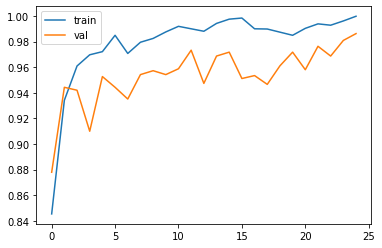

In [ ]:
plt.plot(history.history["accuracy"],label="train")
plt.plot(history.history["val_accuracy"],label="val")
plt.legend()

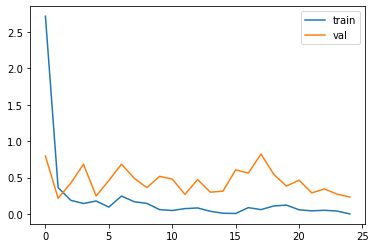

In [ ]:
plt.plot(history.history["loss"],label="train")
plt.plot(history.history["val_loss"],label="val")
plt.legend()

In [ ]:
model1.evaluate(X_test,y_test)

41/41 [==============================] - 7s 165ms/step - loss: 0.2322 - accuracy: 0.9863


[0.23218804597854614, 0.986270010471344]

In [ ]:
y_pred = model1.predict(X_test).argmax(axis=1)
y_pred

41/41 [==============================] - 7s 166ms/step


array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
matrix = confusion_matrix(y_test,y_pred)

In [ ]:
matrix

array([[286,  14,   0,   0],
       [  2, 302,   1,   1],
       [  0,   0, 405,   0],
       [  0,   0,   0, 300]])

In [ ]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix.sum() - (FP + FN + TP)
print(TP)
print(TN)
print(FP)
print(FN)


[286 302 405 300]
[1009  991  905 1010]
[ 2 14  1  1]
[14  4  0  0]


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       300
           1       0.96      0.99      0.97       306
           2       1.00      1.00      1.00       405
           3       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [ ]:
model1.save("CNN_MODEL_0_98627.h5")

### Resnet152 Architecture

In [ ]:
from keras.applications.resnet import ResNet152

In [ ]:
conv_base1 = ResNet152(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

234698864/234698864 [==============================] - 11s 0us/step


In [ ]:
conv_base1.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
model2 = Sequential()

model2.add(conv_base1)

model2.add(Flatten())
model2.add(Dense(512,activation="relu"))
model2.add(Dense(512,activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(4,activation="softmax"))


In [ ]:
conv_base1.trainable = False

In [ ]:
model2.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
history = model2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test))

Epoch 1/25
179/179 [==============================] - 70s 330ms/step - loss: 3.3264 - accuracy: 0.8358 - val_loss: 0.2849 - val_accuracy: 0.9169
Epoch 2/25
179/179 [==============================] - 56s 313ms/step - loss: 0.3470 - accuracy: 0.9200 - val_loss: 0.3761 - val_accuracy: 0.9214
Epoch 3/25
179/179 [==============================] - 56s 316ms/step - loss: 0.2166 - accuracy: 0.9489 - val_loss: 0.3738 - val_accuracy: 0.9169
Epoch 4/25
179/179 [==============================] - 56s 313ms/step - loss: 0.1603 - accuracy: 0.9606 - val_loss: 0.2263 - val_accuracy: 0.9413
Epoch 5/25
179/179 [==============================] - 56s 315ms/step - loss: 0.0847 - accuracy: 0.9764 - val_loss: 0.2383 - val_accuracy: 0.9535
Epoch 6/25
179/179 [==============================] - 56s 312ms/step - loss: 0.1109 - accuracy: 0.9790 - val_loss: 0.3989 - val_accuracy: 0.9336
Epoch 7/25
179/179 [==============================] - 56s 313ms/step - loss: 0.1455 - accuracy: 0.9753 - val_loss: 0.3495 - val_ac

In [ ]:
model2.evaluate(X_test,y_test)

41/41 [==============================] - 10s 250ms/step - loss: 0.2068 - accuracy: 0.9710


[0.20681874454021454, 0.9710144996643066]

In [ ]:
y_pred = model2.predict(X_test).argmax(axis=1)
y_pred

41/41 [==============================] - 12s 241ms/step


array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [ ]:
confusion_matrix = confusion_matrix(y_test,y_pred)

In [ ]:
accuracy_score(y_test,y_pred)

0.9710144927536232

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       300
           1       0.92      0.97      0.94       306
           2       1.00      1.00      1.00       405
           3       0.99      0.98      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [ ]:
confusion_matrix

array([[276,  24,   0,   0],
       [  5, 297,   1,   3],
       [  0,   0, 405,   0],
       [  3,   2,   0, 295]])

In [ ]:
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)
print(TP)
print(TN)
print(FP)
print(FN)


[276 297 405 295]
[1003  979  905 1008]
[ 8 26  1  3]
[24  9  0  5]


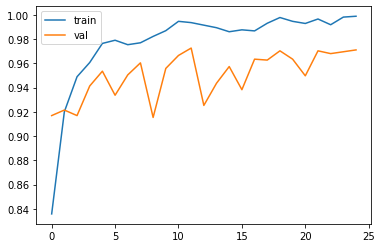

In [ ]:
plt.plot(history.history["accuracy"],label="train")
plt.plot(history.history["val_accuracy"],label="val")
plt.legend()

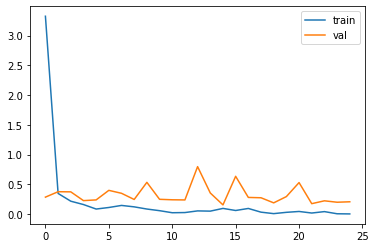

In [ ]:
plt.plot(history.history["loss"],label="train")
plt.plot(history.history["val_loss"],label="val")
plt.legend()

In [ ]:
model2.save("CNN_MODEL_0_97101.h5")